<font size=10>
<center><b> Bank Accounts or Service Complaints </b></center>
</font>

<font size="3"> 
<br>The data comes from: https://query.data.world/s/rd2gbtkdfthsaxhlpyvpwhhv2dwsc2 
</font>

<font size="6">
<b>Importations</b>
</font>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

<font size="6">
<b>Constants</b>
</font>

In [2]:
PATH_CSV_DATA = "Bank_Account_or_Service_Complaints.csv"

<font size="6">
<b>Functions</b>
</font>

In [3]:
def plot_chart(col_data: pd.Series, chart_type: str, number_keep: int = 10000,
               ascending: bool = False, sort_by_index: str = False, x_label: str = None) -> pd.DataFrame:
    """
    Plot a bar chart, where the X-Axis contains the unique values of the Series, and the Y-Axis, the number of occurrences.

    Parameters
    ----------
    col_data : pandas Series
    chart_type : str, {"bar", "pie"}
        Type of chart to plot
    number_keep : int, default 15
        Limit the number of different values to consider during the plot
    ascending : bool, default False
        If False, take the most frequent `number_max` column values; otherwise, take the least frequent ones
    sort_by_index : bool, False
        If True, the figure is sorted by the values
    x_label : str
        If specified, assign it to the xlabel of the figure (axis of values)
        
    Returns
    -------
    DataFrame
        Containing the unique values of the Series and their occurences
    
    """
    # Verify that the chart_type is correct 
    if chart_type not in ["bar", "pie"]:
        raise ValueError("'chart_type' must be either 'bar' or 'pie' !")
        
    # Count the values' frequency and sort them by value
    data_to_plot = col_data.value_counts(ascending=ascending)
    
    # If number_keep is less than the number of values, we sum up the other values into a row 'Others'
    number_total = len(data_to_plot)
    if number_keep < number_total:
        data_to_plot.iloc[number_keep] = data_to_plot.tail(number_total - number_keep).sum()
        data_to_plot = data_to_plot.rename({data_to_plot.index[number_keep]: "Others"})\
                                   .head(number_keep + 1)
    
    
    # Sort the result by index if requested
    if sort_by_index:
        data_to_plot.sort_index(inplace=True)

    # Plot configuration
    plt.xlabel(x_label, {"size": 14})

    # Plot the requested graph
    if chart_type == "bar":
        plt.ylabel("Number of occurences", {"size": 14})
        plt.bar(data_to_plot.index, data_to_plot.values[:])
    else:
        plt.pie(data_to_plot.values[:], labels=data_to_plot.index, autopct=lambda p: f"{p:.2f}%")

    return data_to_plot


def encode_column(col: np.ndarray, max_unique_values: int = 100) -> np.ndarray:
    """
    Encode a numpy array
    
    Parameters
    ----------
    col : numpy 1D-Array
    max_unique_values : int, default 100
        Limit the number of unique values to use
        Take the most occurents and regroup all the others in one value

    Returns
    -------
    numpy 2D-Array
        Encoded Array
    
    
    """
    # Get the unique values and their frequences in the list
    col_values = np.unique(col, return_counts=True)
    
    # If there are only two unique values, we use a labelencoder, otherwise we use a onehotencoder
    n_unique_values = len(col_values[0]) 
    if n_unique_values <=2 : 
        labelencoder = LabelEncoder()
        encoded_col = labelencoder.fit_transform(col.reshape((len(col), 1)))
    else:
        # Find the `max_unique_values` most occurent unique values in the column
        col_values = [(val,freq) for (val,freq) in zip(col_values[0], col_values[1])]
        col_values.sort(key=lambda x: x[1])
        values_keep = [col_values[i][0] for i in range(min(max_unique_values, n_unique_values))]
        
        # Keep the most occurent unique values, and change all the others to a value "Others"
        col = np.array([value if value in values_keep else "Others" for value in col])
        
        # Use a hot encoder
        onehotencoder = OneHotEncoder()
        encoded_col = onehotencoder.fit_transform(col.reshape((len(col), 1))).toarray()
    
    return encoded_col

<font size="6">
<b>Core Analysis</b>
</font>

<font size="4">
<b>General look:</b>
</font>

In [4]:
# Load the data from the csv file into a dataframe
df_data = pd.read_csv(PATH_CSV_DATA)

# Show the dataframe
df_data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/29/2013,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,07/31/2013,Closed with explanation,Yes,No,468889
1,07/29/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065,NaN,NaN,Fax,07/31/2013,Closed,Yes,No,468879
2,07/29/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,GA,30084,NaN,NaN,Web,07/30/2013,Closed with explanation,Yes,No,468949
3,07/29/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Bank of America,TX,75025,NaN,NaN,Web,07/30/2013,Closed with explanation,Yes,No,468981
4,07/29/2013,Bank account or service,Other bank product/service,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,CA,96088,NaN,NaN,Web,08/01/2013,Closed with explanation,Yes,No,469185


<font size="4">
<b>Shape and data structure:</b>
</font>

In [5]:
# Visualize the shape, and the data type of each column
print(f"- Shape : {df_data.shape}\n")
print(f"- Data types :\n\n{df_data.dtypes}")

- Shape : (84811, 18)

- Data types :

Date received                    object
Product                          object
Sub-product                      object
Issue                            object
Sub-issue                       float64
Consumer complaint narrative     object
Company public response          object
Company                          object
State                            object
ZIP code                         object
Tags                             object
Consumer consent provided?       object
Submitted via                    object
Date sent to company             object
Company response to consumer     object
Timely response?                 object
Consumer disputed?               object
Complaint ID                      int64
dtype: object


<font size=4>
<b>Data values:</b>
</font>

<font size=3>
First, let's check if there are any missing data.
</font>

In [6]:
df_data.isna().sum()

Date received                       0
Product                             0
Sub-product                         0
Issue                               0
Sub-issue                       84811
Consumer complaint narrative    70951
Company public response         61820
Company                             0
State                            1549
ZIP code                         1550
Tags                            73179
Consumer consent provided?      62439
Submitted via                       0
Date sent to company                0
Company response to consumer        0
Timely response?                    0
Consumer disputed?               4031
Complaint ID                        0
dtype: int64

<font size=3>
<ul><li> There are many missing values : More than <b>70%</b> of the values are missing from the columns "Sub-issue", "Consumer complaint narrative", "Company public response", "Tags" and "Consumer consent provided?"<br><br>
<li> The number of missing values in the column <b>"Sub-issue"</b> equals the total number of rows. Therefore, it is an empty column. </ul> 
</font>

<font size="3"> 
Let's now take a look at the number of unique values per column.
</font>

In [7]:
df_data.nunique()

Date received                    1864
Product                             1
Sub-product                         5
Issue                               5
Sub-issue                           0
Consumer complaint narrative    13831
Company public response            10
Company                           451
State                              62
ZIP code                        15145
Tags                                3
Consumer consent provided?          4
Submitted via                       6
Date sent to company             1712
Company response to consumer        8
Timely response?                    2
Consumer disputed?                  2
Complaint ID                    84811
dtype: int64

<font size="3">
<ul><li>The column <b>"Product"</b> has a unique value, which makes it irrelevant to study. <br><br>
<li>There is 0 value in the column <b>"Sub-issue"</b>, which confirms that it is empty. <br><br>
<li>There is one different <b>"Complaint ID"</b> for each row. It is normal because it is a specific ID.</ul>
</font>

<font size=4>
<b>Complaints per state:</b>
</font>

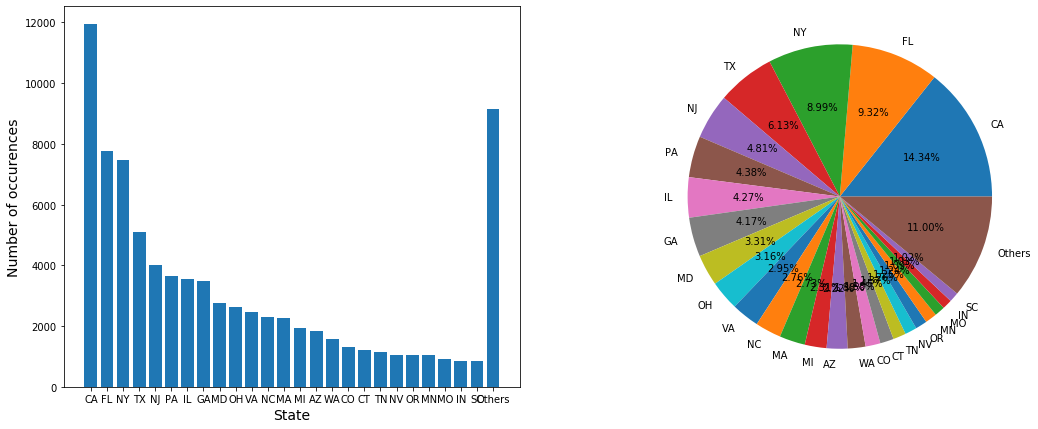

In [8]:
# Create a figure
fig = plt.figure(figsize=(18,7))

# Plot a bar chart of the 25 states which receive the biggest number of complaints
ax1 = fig.add_subplot(1,2,1)
plot_chart(df_data["State"], "bar", number_keep=25, x_label="State")

# Plot a pie chart for all the states in a second subplot
ax2 = fig.add_subplot(1,2,2)
plot_chart(df_data["State"], "pie", number_keep=25)

plt.show()

<font size="3">
The number of complaints is very different from a state to another : 
<ul><li>The Biggest number of complaints happens to be in California. It is almost 12 000, which corresponds to<b> 14,34 % </b>of the total number of complaints.
    <li><b>More than 50%</b> of the complaints concerns only 7 states ("CA", "FL", "NY", "TX", "NJ", "PA", "IL"), which is huge since there are 62 states in total.</ul>
</font>

<font size=4>
<b>Complaints per company:</b>
</font>

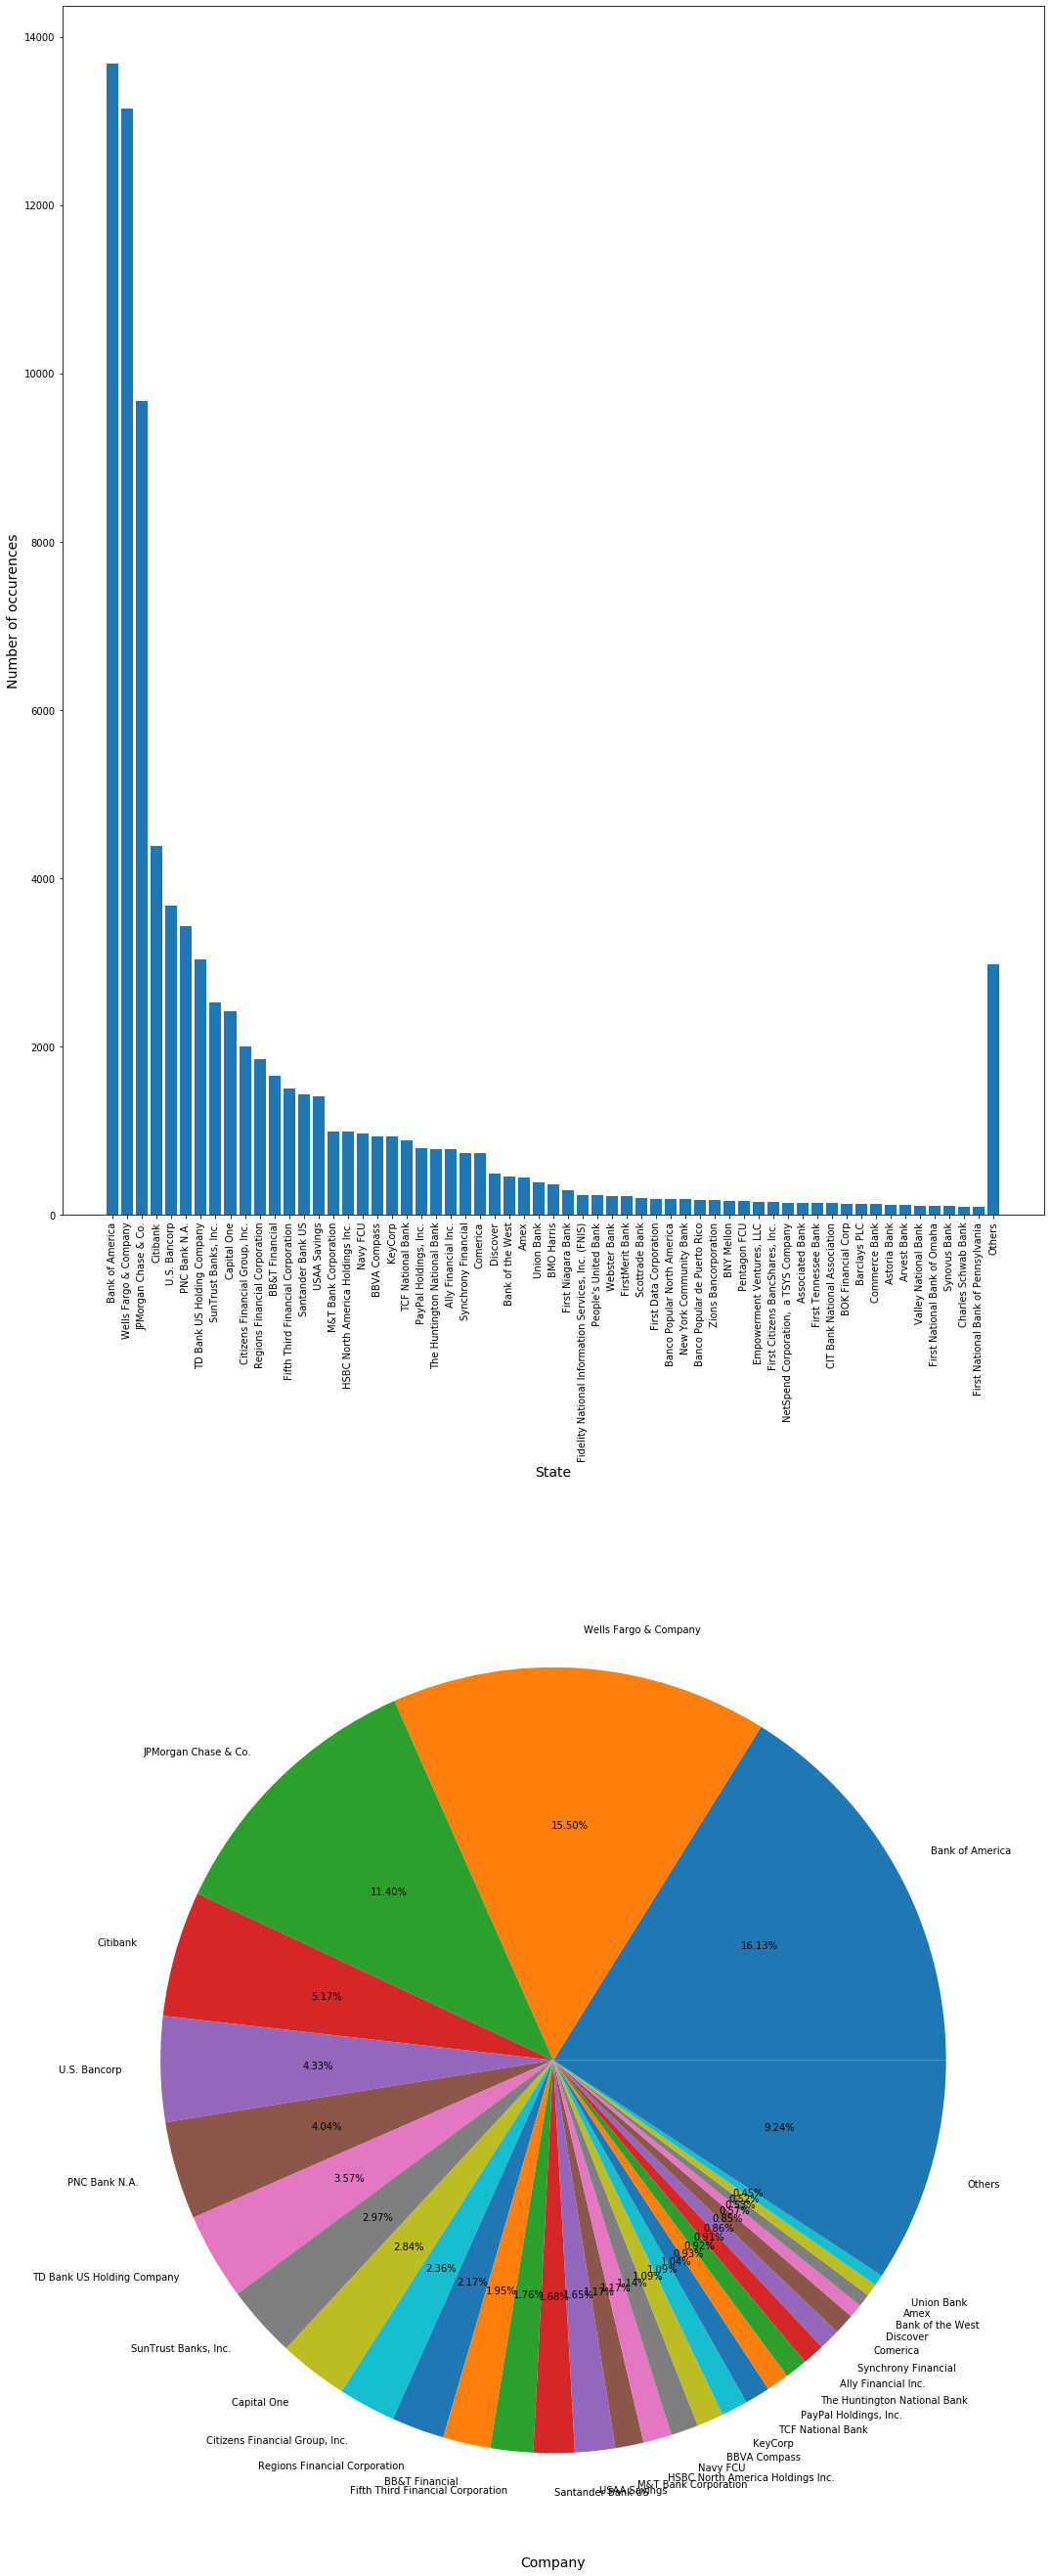

In [9]:
# Create a figure
fig = plt.figure(figsize=(18,50))

# Plot the bar chart showing the number of complaints per company
ax1 = fig.add_subplot(2,1,1)
plt.xticks(rotation=90)
plot_chart(df_data["Company"], "bar", x_label="State", number_keep=60)

# Plot the pie chart showing the number of complaints per company
ax2 = fig.add_subplot(2,1,2)
plot_chart(df_data["Company"], chart_type="pie", x_label="Company", number_keep=30)

plt.show()

<font size="3">
From the graph above, we can see that the number of complaints is huge within some companies, like "Bank of America" with around 13800 (16%) or "Wells Fargo & Company" with almost 13200 (15,50%).<br><br>
Comparing to that, there are very few complaints among the other companies, since <b>"Others" represent 421 companies and it is only 9,24% of the total number of complaints</b>. 
</font>

<font size=4>
<b>Complaints per Month/Year:</b>
</font>

In [10]:
# Add two columns : Year and Month 
df_date_received = df_data["Date received"].str.split("/", expand=True)

df_data["Month"] = df_date_received[0]
df_data["Year"] = df_date_received[2]

<font size="3">
First, let's see how the number of complaints evolves through the years.
</font>

2012    12224
2013    13388
2014    14665
2015    17141
2016    21850
2017     5543
Name: Year, dtype: int64

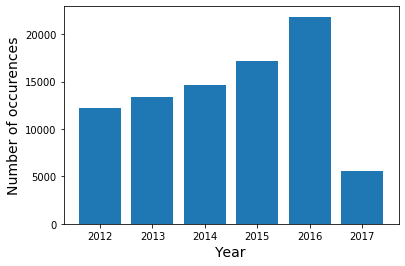

In [11]:
plot_chart(df_data["Year"], chart_type="bar", sort_by_index=True, x_label="Year")

<font size="3">
The number of complaints seems to be <b>increasing from a year to another</b>. However, it decreased drastically in 2017. Is it because the bank performed so well that there was no more things to complain about, or is it simply because the data does not cover the entire year ? <br><br>
In order to confirm one of the hypothesis, we need to check when was the last received complaint.       
</font>

In [12]:
# Get two of the newest complaints regarding the year and the month 
df_data.sort_values(["Year", "Month"]).tail(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Month,Year
74665,04/01/2017,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,JPMorgan Chase & Co.,CO,80134,NaN,NaN,Web,04/01/2017,In progress,Yes,NaN,2414594,04,2017
74680,04/01/2017,Bank account or service,Checking account,"Account opening, closing, or management",NaN,After having a checking and joint checking acc...,Company has responded to the consumer and the ...,Wells Fargo & Company,FL,336XX,Older American,Consent provided,Web,04/01/2017,Closed with explanation,Yes,NaN,2414596,04,2017


<font size="3">
    As expected, <b>the data only covers the first four months of the year 2017</b>. Therefore, we cannot make any conclusion regarding the increase or decrease of the number of complaints for the last year.
    <br><br>The previous finding makes us wonder as well about the first year (2012), whether it was fully-covered or not.  
</font>

In [13]:
# Get one of the oldest complaint in the dataframe regarding the year and the month
df_data.sort_values(["Year", "Month"]).head(1)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Month,Year
11877,03/12/2012,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,CA,92064,NaN,NaN,Referral,03/16/2012,Closed without relief,Yes,No,17504,03,2012


<font size="3">
    The <b>first complaint received was on March 2012</b>, which means that the data for the two first months is missing. Therefore, since we don't have enough information, it is even possible that the number of complaints was higher in 2012 than in 2013.<br><br>
    In conclusion, all we can say about the number of complaints per year is that it was <b>increasing from 2013 to 2016</b>.<br><br>
    Now, let's look at the number of complaints per month.
    
</font>

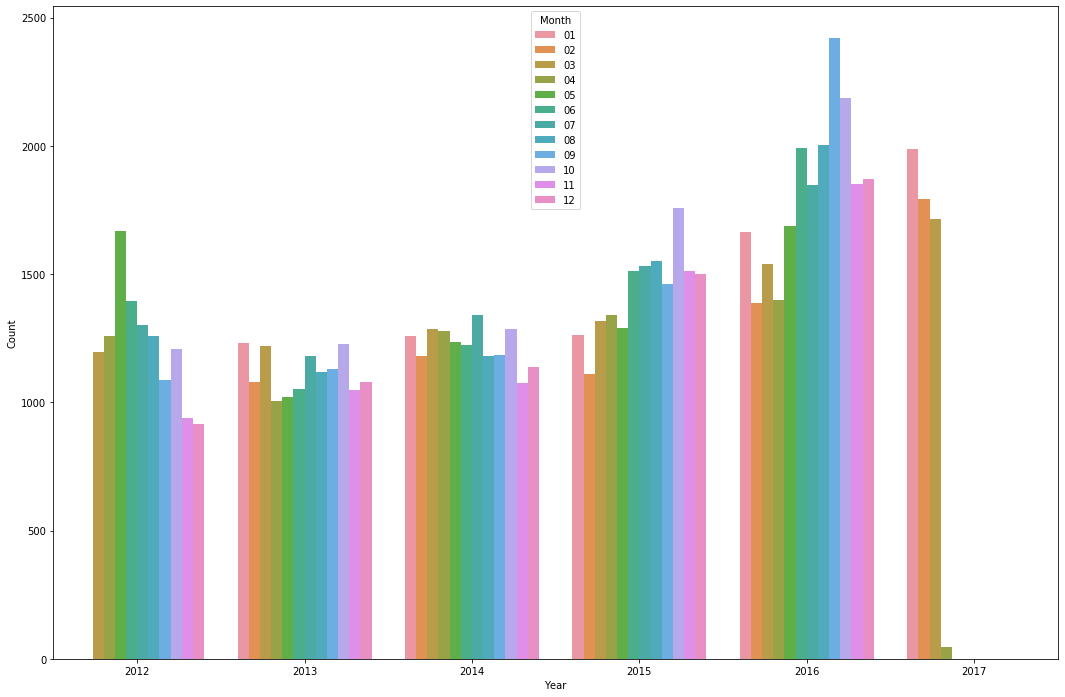

In [14]:
# Group the complaints per year and month, and count them
complaints_per_month = df_data.groupby(["Year", "Month"]).size().reset_index(name="Count")

# Plot a bar chart
plt.figure(figsize=(18,12))
sns.barplot(x="Year", y="Count", hue="Month", data=complaints_per_month)

plt.show()

<font size="3">
    From the graph above, the number of complaints seems to be incorrelated with the month.
    
</font>

<font size=4>
<b>Delay to send complaints to company:</b>
</font>

In [15]:
# Convert the columns "Date received" and "Date sent to company" into timestamps 
df_data.loc[:, "Date received"] = df_data["Date received"].apply(datetime.strptime, args=("%m/%d/%Y",))
df_data.loc[:, "Date sent to company"] = df_data["Date sent to company"].apply(datetime.strptime, args=("%m/%d/%Y",))

# Add a column for the delay between both dates
df_data["Delay"] = (df_data["Date sent to company"] - df_data["Date received"]).map(lambda x: x.days)


In [16]:
df_data["Delay"].describe()

count    84811.000000
mean         2.994022
std         10.199615
min         -1.000000
25%          0.000000
50%          1.000000
75%          4.000000
max        606.000000
Name: Delay, dtype: float64

<font size="3">
    <ul><li>The mean time for a complaint to be sent to the company is 3 days, but more than 50% are sent within a day, which is correct.
        <li> Strangely, There are complaints that have been sent to the company one day before being received, how is it possible ? 
        <li> One complaint took almost 2 years (606 days) to reach the company, what happened ?
    </ul>
</font>

<font size=4>
<b>Predict 'Timely response?':</b>
</font>

<font size="3">
    In this part, we are gonna try to predict is a response is timely or not.<br><br>
    First, let's see if the data is balanced between the two classes:
</font>

In [17]:
num_samples = df_data.shape[0]
classes = pd.value_counts(df_data["Timely response?"])

print(f"Number of Timely responses: {classes['Yes']} | Percentage : {100 * classes['Yes'] / num_samples:.2f} %")
print(f"Number of Non-Timely responses  : {classes['No']} | Percentage : {100 * classes['No'] / num_samples:.2f} %")

Number of Timely responses: 82626 | Percentage : 97.42 %
Number of Non-Timely responses  : 2185 | Percentage : 2.58 %


<font size="3">
    The data is really imbalanced, we are gonna try to balance it during the process.<br><br>
    Let's prepare the features and the target.
</font>

In [18]:
# Create a new sub-dataframe 
df_data_pred = df_data[["Sub-product", "Issue", "Company", "State",
                        "Tags", "Submitted via", "Company response to consumer", "Timely response?"]]

# Remove the rows with NaN in State
df_data_pred = df_data_pred[df_data_pred["State"].notnull()]

# Change NaN values in the column "Tags"
df_data_pred.fillna("Unspecified", inplace=True)

# Prepare the input matrix
values_data_pred = df_data_pred.values[:]
number_columns = values_data_pred.shape[1]

# Prepare the features
features = []
for i in range(number_columns - 1):
    col_encoded = encode_column(values_data_pred[:,i], 20)
    features.append(col_encoded)
X = np.concatenate(features, axis=1)
print(f"Shape of X : {X.shape}")

# Prepare the target
y = encode_column(values_data_pred[:, number_columns - 1])
print(f"Shape of y : {y.shape}")

Shape of X : (83262, 70)
Shape of y : (83262,)


/home/mdassouli/miniconda3/envs/.bank_account/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<font size="3">
    Let's split the data into a training and a testing sets, and try to resample it for the training part.
</font>

In [19]:
# Split the data into a training and testing sets
ssp = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
ssp.get_n_splits(X, y)
for train_index, test_index in ssp.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# Resample the data since it is imbalanced
"""resampler = SMOTEENN(random_state=0)
X_train, y_train = resampler.fit_resample(X_train, y_train.astype(int))"""
#NOTE: The resampling might take few minutes, uncomment if you want to perform it

<font size="3">
    We define a classifier and fit it.
</font>

In [40]:
# Define the classifier
clf = RandomForestClassifier(max_depth=16, min_samples_split=5, random_state=0)

# Fit the classifier
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

<font size="3">
    Check the metrics of the classifier : 
</font>

Test Set:
              precision    recall  f1-score   support

           0       0.11      0.05      0.06       430
           1       0.98      0.99      0.98     16223

    accuracy                           0.97     16653
   macro avg       0.54      0.52      0.52     16653
weighted avg       0.95      0.97      0.96     16653

[[   20   410]
 [  166 16057]]


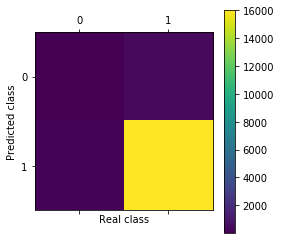

In [41]:
report = classification_report(y_true=y_test.astype(int), y_pred= clf.predict(X_test))
matrix = confusion_matrix(y_true=y_test.astype(int), y_pred=clf.predict(X_test))
print("Test Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel("Real class")
plt.ylabel("Predicted class")
plt.show()

<font size="3">
    Even though the accuracy is high (95 %), <b>the model is very weak since it cannot predict well the class 0 (Precision : 11 %, Recall 5 %)</b>.<br><br>
    We could improve its performance by using a grid search to find the best hyperparameters. But there is no guarantee that we will reach very high levels, especially if "Timely response" is not strongly correlated to the input features we used.
</font>